## A new set of classes for mental image registration

In [2]:
from imagery_psychophysics.utils.variational_utils import *
from imagery_psychophysics.src.variational import responses, noiseParams, probes, inferQZ, optimizeNoiseParams
from imagery_psychophysics.src.variational import to_one_hot_func
from object_parsing.src.image_objects import object_box, mask_quantize
from skimage.transform import AffineTransform, matrix_transform, resize, SimilarityTransform
from scipy.interpolate import griddata
from scipy.ndimage import center_of_mass
from scipy.stats import poisson
from matplotlib import pyplot as plt
from copy import copy, deepcopy
from PIL.Image import fromarray
from scipy.linalg import expm
from scipy.stats import norm
from sklearn.metrics.pairwise import pairwise_distances
from theano import tensor as T
from theano.tensor.extra_ops import repeat, to_one_hot
from theano import function, shared
import time
import pandas as pd

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_8xkOMl.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda: GeForce GTX TITAN X (0000:01:00.0)


In [3]:
floatX = 'float32'
intX = 'int32'

In [4]:
windows, resp, _, targetObjectMap,targetImage = open_imagery_probe_data('KL', 'pcp', 'peaches_05')

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


#### Utilities

In [5]:
def source_points(shape):
    D1,D2 = shape
    sourceI, sourceJ= np.meshgrid(range(D1),range(D2))
    sourcePoints = np.array([sourceJ.flatten(),sourceI.flatten()]).T.astype('float64')
    return sourcePoints


#box = (left, upper, right, lower)
def get_box_center(boxtuple):
    left, upper, right, lower = boxtuple
    center_row = np.median([upper, lower])
    center_col = np.median([left, right])
    return np.array([center_row, center_col])

def compose_and_iterate(sourcePoints, transformFuncList, activations=None, iterations=1):
    displacedPoints = copy(sourcePoints)
    if iterations:
        ##apply transforms in series, noting activations, and assuming that xForm manages control point arithmetic
        if activations is None:
            activations = [1]*len(transformFuncList)
        for xForm,a in zip(transformFuncList,activations):
            if not a:
                xForm = lambda x: x
            displacedPoints = xForm(displacedPoints)
        ##reduce iterations
        iterations -= 1
        return compose_and_iterate(displacedPoints, transformFuncList, activations, iterations=iterations)
    else:
        return displacedPoints

        

def local_affine_warp(sourcePoints, controlPoint, baseTransformMatrix, scaleFunction):
    
    r = pairwise_distances(sourcePoints, controlPoint[np.newaxis,:])
    scalars = scaleFunction(r)  
    scaledXForms = scalars[:,:,np.newaxis]*baseTransformMatrix
    xForms = np.array(map(expm, scaledXForms))

    displacedPoints = np.sum((sourcePoints[:,:,np.newaxis]-controlPoint.T)*xForms,axis=2)+controlPoint

    return displacedPoints,xForms

In [6]:
##a basis set for globally affine distortions
def global_affine_distortion_set(big=1.2, small=.8, rotate=np.pi/16., shear = np.pi/16., translate=3):

    globalAffineParamDictList = []
    globalAffineParamDictList += [{'scale':(big,1.), 'rotation':None, 'shear':None, 'translation':None}]
    globalAffineParamDictList += [{'scale':(1.,big), 'rotation':None, 'shear':None, 'translation':None}]
    globalAffineParamDictList += [{'scale':(small,1.), 'rotation':None, 'shear':None, 'translation':None}]
    globalAffineParamDictList += [{'scale':(1.,small), 'rotation':None, 'shear':None, 'translation':None}]
    globalAffineParamDictList += [{'scale':None, 'rotation':rotate, 'shear':None, 'translation':None}]
    globalAffineParamDictList += [{'scale':None, 'rotation':-rotate, 'shear':None, 'translation':None}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':rotate, 'translation':None}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':-rotate, 'translation':None}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(translate,0)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(0, translate)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(-translate, 0)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(0, -translate)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(translate, -translate)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(-translate, translate)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(translate, translate)}]
    globalAffineParamDictList += [{'scale':None, 'rotation':None, 'shear':None, 'translation':(-translate, translate)}]
    return globalAffineParamDictList

In [7]:
##a basis set for local affine distortions
def local_affine_distortion_set(big=.2, small=-.2):

    localAffineParamDictList = []
    localAffineParamDictList += [{'scale':(big,big), 'rotation':None, 'shear':None, 'translation':None}]
#     localAffineParamDictList += [{'scale':(0.,big), 'rotation':None, 'shear':None, 'translation':None}]
    localAffineParamDictList += [{'scale':(small,small), 'rotation':None, 'shear':None, 'translation':None}]
#     localAffineParamDictList += [{'scale':(0.,small), 'rotation':None, 'shear':None, 'translation':None}]
    return localAffineParamDictList

#### Variational machinery

In [8]:
class activationPrior(object):
    def __init__(self):
        self._activationProb = T.scalar('activationProb',dtype=floatX)
        
    def set_value(self,value):
        assert value <= 1
        assert value >= 0
        self.activationProb = np.array(value,dtype=floatX)
    

In [9]:
class iterationPrior(object):
    def __init__(self):
        self._iterationMean = T.scalar('iterationMean', dtype=floatX)        
        
    def set_value(self,value):
        assert value >= 0
        self.iterationMean = np.array(value,dtype=floatX)
    
    def pmf(self, num):
        return poisson.pmf(num,self.iterationMean)
    
        

In [10]:
class baseObjectMap(object):
    '''
    
    '''
    def __init__(self,objectMap):
        from PIL.Image import fromarray
        '''
        baseObjectMap(objectMap)
        an object map in cannonical form, i.e., a D1 x D2 discrete numpy array
        
        '''
        self.objectMap = self._convert_object_labels(objectMap)
        self.D1 = self.objectMap.shape[0]
        self.D2 = self.objectMap.shape[1]
        self.D = np.prod([self.D1,self.D2])
        self.sourcePoints = source_points((self.D1,self.D2))
        self.objectCenters = self._get_object_centers()
        
        ##theano expressions
        self._D1 = T.scalar('numPixelRows',dtype=intX) ##num pixel rows
        self._D2 = T.scalar('numPixelCols',dtype=intX) ##num pixel cols
        self._D = self._D1*self._D2 ##total number of pixels
        self._D.name = 'numPixels'
        self._K = T.scalar('numObjects',dtype=intX) ##a theano integer scalar       
    
    def _convert_object_labels(self,objectMap):
        self.nativeLabelList = np.unique(objectMap).tolist()
        self.K = len(self.nativeLabelList)
        return np.digitize(objectMap, self.nativeLabelList,right=True)
        
        
    def _get_object_centers(self):        
        objectCenters = np.empty((self.K,2),dtype=floatX)
        for objectLabel in range(self.K):
            box = object_box(fromarray(self.objectMap.astype('uint8')),objectLabel)
            objectCenters[objectLabel,:] = get_box_center(box)[np.newaxis,:].astype(floatX)
        return objectCenters

In [11]:
class distortions(object):
    def __init__(self, controlPoints,kind='global',distortionParamDictList=[{'scale':None, 'rotation':None, 'shear':None, 'translation':None}],scale=10.):

        '''
        distortions(controlPoints,
                    kind='global',
                    distortionParamDictList=[{'scale':None,
                                              'rotation':None,
                                              'shear':None, 
                                              'translation':None}],
                                              scale=10.))
        the basic job of this class is to create a list of image distortions.
        these distortions will be composed and applied to an image downstream.
        
        inputs:
        
        controlPoints ~ M x 2 array of points about which the distortions will be applied
        
        distortionParamDistList ~ list of lenght G of dicts with distortion params.
            {'scale':None, 'rotation':None, 'shear':None, 'translation':None}
            default is the id matrix. scale takes (sx,sy), values <0 shrink.
            translation takes (tx,ty).
            shear and rotation take angles in radians.

        kind ~ "local" or "global". if local, use a locally affine warping approach. if
            global, interpret params as globally affine. Note: "global" is MUCH faster.
        
        scale ~ scalar. if kind = 'local', this defines locality. otherwise ignore.
            Note: if small, very local and distortions are locally "strong". 
            if big, distortions apply almost globally but are very "weak".
            
        attributes:
        
        transformFuncList ~ list of warping functions like warpfunc(sourcePoints)
            where sourcePoints is D x 2 array of points to displace. these functions
            should return an D x 2 array of "displaced points" that will be used
            downstream to interpolate. the lenght of this list will be MxG.
            this is the number of controlPoints (M) times number of distortions (G).
            all distortions for one control point are in contiguous segment of the list.
      
        '''
        
        
        self.kind = kind
        self.controlPoints = controlPoints
        self.numControlPoints = controlPoints.shape[0]
        self.distortionParamDictList = distortionParamDictList
        self.numDistortions = len(self.distortionParamDictList)
        if kind == 'local':
            self.scale = scale
        self._get_transform_function_list()
        
    def _get_transform_function_list(self):
        self.transformFuncList = []
        if self.kind == 'global':
            for ctrlPt in self.controlPoints:
                for paramDict in self.distortionParamDictList:
                    xForm = AffineTransform(**paramDict)
                    self.transformFuncList += [lambda x,bc=ctrlPt,xf=xForm.params.astype(floatX): matrix_transform(x-bc,xf)+bc]
        elif self.kind == 'local':
            scaleFunc = lambda r,scale_param=self.scale: norm.pdf(r, scale=scale_param)
            for ctrlPt in self.controlPoints:
                for paramDict in self.distortionParamDictList:
                    xForm = AffineTransform(**paramDict)
                    baseTransformMatrix = xForm.params[:2,:2].astype(floatX)
                    self.transformFuncList += [lambda x, btm=baseTransformMatrix, cp=ctrlPt: local_affine_warp(x,cp,btm, scaleFunc)[0]]
        else:
            raise ValueError('keyword "kind" must be either "global" or "local" ')

In [12]:
def renormalize_double(pval):
    return pval.astype('float64') / np.sum(pval.astype('float64'),axis=0)



In [13]:
class activations(object):
    def __init__(self, activationPrior_inst, distortions_inst):
        self.activationPrior = activationPrior_inst
        self.distortions = distortions_inst
        self._A = T.vector('activationVector', dtype=intX)
        self.numActivationVars = self.distortions.numControlPoints*self.distortions.numDistortions
        self.numActivationStates = 2  #can be on or off (1, 0)
    
    def sample(self, M = 1, pval=None, kind='1hot'):
        '''
        sample(M = 1, pval=None)
        
        if pval supplied, should be numActivationStates x numActivationVars array
        each colum is probability that activation = [1,0]. top row is ON, bottom is OFF,
        bottom = 1-top.
        if not supplied, use prior probability to sample.
        
        if kind = '1hot', returns an M x numActivationStates x numActivationVars array
        if kind = 'canonical', returns an M x numberActivationVars array, each element a 0 or 1
        '''
       
        
        if pval is None:
            pval = self.activationPrior.activationProb
            pval = np.array([pval, 1-pval],ndmin=1)
            pval = renormalize_double(pval)
            activations = np.random.multinomial(1, pval, size=(M,self.numActivationVars)).transpose([0,2,1])
        else:
            assert pval.shape == (self.numActivationStates, self.numActivationVars)
            activations = np.empty((M,self.numActivationStates, self.numActivationVars), dtype=intX)
            pval = renormalize_double(pval)
            for v in range(self.numActivationVars):
                activations[:, :, v] = np.random.multinomial(1,pval[:,v], size=M)
        if kind == '1hot':
            return activations
        elif kind == 'canonical':
            return np.argmin(activations,axis=1) ##argmin becuase ON is coded as first element of each column.
        else:
            raise ValueError('keyword "kind" must be "canonical" or "1hot"')
             


In [14]:
##this is really a class for the variational posterior. it samples from
##a discrete distribution over "number of iterations". whereas the prior over number of iterations
##is a poisson, and the true posterior over number of iterations is wtfk.
class iterations(object):
    def __init__(self, iterationPrior_inst, numIterationVars=1,numIterationStates=3):
        self.iterationPrior = iterationPrior_inst
        self._t = T.vector('iterationVector',dtype=intX)
        #for now we only support one "global" iteration variable.
        #can range from 0 (no distortion) to upper limit numIterationStates
        self.numIterationVars = numIterationVars
        self.numIterationStates = numIterationStates
    
    def sample(self, pval=None, M=1, kind='1hot'):
        '''
        sample(pval, M=1)
        
        inputs:
        pval ~ array of probabilities, shape = (numIterationStates,numIterationVars)
            each column is a 1hot encoding of probability of number of iterations from 0 up to some
            truncated value (numberIterationStates)
            if pval=None, sample from uniform distribution
            
        M ~ number of samples
        kind ~ "cannoical" or "1hot"

        
        returns:
        iterations ~ if kind="canonical", an M x numIterationVars array, each element is number of iterations.
            if kind = "1hot", an M x numIterationStates x numIterationVars array. each for a fixed sample, 
            the column is a 1-hot encoding of number of iterations. so like iterations[m,k,n] = 1 would mean
            that for the m_th sample, the number of iterations for the n_th iteration variable is k.
        
        
        '''
        
        
        if pval is None:
            pval = np.empty((self.numIterationStates, self.numIterationVars), dtype=floatX)
            pval[:] = 1./self.numIterationStates
        assert pval.shape == (self.numIterationStates, self.numIterationVars)
        iterations = np.empty((M, self.numIterationStates, self.numIterationVars), dtype=intX)
        pval = renormalize_double(pval)
        for v in range(self.numIterationVars):
            iterations[:, :, v] = np.random.multinomial(1,pval[:,v], size=M)
        if kind == '1hot':
            return iterations
        elif kind == 'canonical':
            return np.argmax(iterations,axis=1)
        else:
            raise ValueError('keyword "kind" must be "canonical" or "1hot"')



In [498]:
class latentObjectMap(object):
    def __init__(self, activations_inst, iterations_inst, baseObjectMap_inst):
        self.activations = activations_inst
        self.iterations = iterations_inst
        self.baseObjectMap = baseObjectMap_inst
        self._Z = T.tensor3('Z',dtype=intX) #M x K x D stack of object maps
        self._K = T.scalar('numObjects',dtype='int32') ##a theano integer scalar
        self._D1 = T.scalar('numPixelRows',dtype='int32') ##num pixel rows
        self._D2 = T.scalar('numPixelCols',dtype='int32') ##num pixel cols
        self._D = self._D1*self._D2 ##total number of pixels
        self._D.name = 'numPixels'
         
    def sample(self, M=1, activationProbs=None, iterationProbs=None, kind = '1hot'):
        '''
        sample(M=1, activationProbs=None, iterationProbs=None, kind = '1hot')
        generate M samples of a probabilistically distorted object map
        
        inputs:
        M ~ int, number of samples
        activationProbs ~ nActStates x nActVars array of probabilities, columns sum to 1
        iterationProbs ~ nItStates x nItVars array of probabilities, columns sum to 1
        kind = '1hot', 'canonical'
        
        returns:
        warped,activations,iterations
        
        if kind == 'canonical', warped is M x D1 x D2 array of object maps.
        if kind == '1hot', warped is M x K x D array of 1hot-encoded object maps, K=number of objects, D=D1*D2
        
        activations is M x nActVars
        iterations is M x nItVars
        
        
        '''
        D1,D2 = self._get_dims()
        D = D1*D2
        K = self._get_num_objects()
        baseMap = self._get_base_map()
        activations = self.activations.sample(M=M,pval=activationProbs,kind='canonical')
        iterations = self.iterations.sample(M=M, pval=iterationProbs,kind='canonical')
        sourcePoints = self.baseObjectMap.sourcePoints
        xFormFuncList = self.activations.distortions.transformFuncList
        objectMapStackCanonical = np.empty((M,D1,D2),dtype=intX)
        for m in range(M):
            actList = activations[m].tolist()
            iters = np.copy(iterations[m])
            displacedPoints = compose_and_iterate(sourcePoints, xFormFuncList, actList, iters)
#             objectMapStackCanonical[m,:,:] = griddata(displacedPoints, baseMap, sourcePoints, method='nearest').reshape((D1,D2))
            objectMapStackCanonical[m,:,:] = griddata(displacedPoints, baseMap.T.flatten(), sourcePoints, method='nearest').reshape((D2,D1)).T
        if kind == '1hot':
            objectMapStackOneHot = np.empty((M,K,D),dtype=intX)
            for m in range(M):
                objectMapStackOneHot[m,:,:] = to_one_hot_func(objectMapStackCanonical[m].flatten(),K).T
            return objectMapStackOneHot, activations, iterations,displacedPoints
        elif kind == 'canonical':
            
            return objectMapStackCanonical, activations,iterations
        else:
            raise ValueError('keyword argument "kind" must be "1hot", or "canonical"')
    
    def convert1hot_to_image(self, sample1hot, show=False):
        '''
        convert1hot_to_image(sample1hot, show=False)
        takes a 1 x K x D sample of a 1hot encoded object map 
        and converts it to a D1 x D2 image of the map.

        makes plot if show=True
        '''
        D1,D2 = self._get_dims()
        sampleImage = np.argmax(sample1hot,axis=1).reshape((D1,D2))
        if show:
            plt.imshow(sampleImage, interpolation='nearest')
        return sampleImage   
    
    def _get_dims(self):
        return self.baseObjectMap.objectMap.shape
    def _get_num_objects(self):
        return self.baseObjectMap.K
    def _get_base_map(self):
        return self.baseObjectMap.objectMap

In [499]:
class behavior(responses):
    def __init__(self,latentObjMap_inst, noiseParams_inst):
        ##okay so this is super gross, but these few lines of code allow me to not have to
        ##rewrite the whole class just to change a few variable names
        from imagery_psychophysics.src.variational import numObjects, numPixels, priorDispersion, categoryProbs
        cp = categoryProbs(numObjects(),priorDispersion())
        latentObjMap_inst.categoryPrior = cp
        latentObjMap_inst.numPixels = numPixels()
        super(behavior, self).__init__(latentObjMap_inst, noiseParams_inst)
        
        ##overwrites because the graph is now different. this allows us to reuse a lot of code
        self.Z.categoryPrior.numObjects._K = latentObjMap_inst._K
        self.Z.numPixels._D1 = latentObjMap_inst._D1
        self.Z.numPixels._D2 = latentObjMap_inst._D2
        self.Z.numPixels._D  = latentObjMap_inst._D
        self.Z.categoryPrior.numObjects.K = latentObjMap_inst._get_num_objects()
        self.Z.numPixels.D1,self.Z.numPixels.D2 = latentObjMap_inst._get_dims()
        self.Z.numPixels.D = np.prod(latentObjMap_inst._get_dims())

In [500]:
class variationalImageRegistration(object):
    def __init__(self, behavior_inst, activationInferQZ_inst, iterationInferQZ_inst, optimizeNoiseParams_inst):
        self.responses = behavior_inst
        self.iQA = activationInferQZ_inst
        self.iQt = iterationInferQZ_inst
        self.oNP = optimizeNoiseParams_inst

        ##hard-coded bounds for clipping floating point errors
        self._a_min = 1e-4
        self._a_max = 1
        
        
        ##compile theano expressions, functions
        self.compile_object_probs()
        self.compile_entropy()
        self.compile_predictive_distribution()
        self.compile_goodness_of_fit()
        self.compile_ELBO()
        

        
        
        

    ##===compile theano expressions, functions===
    def compile_object_probs(self):
        _object_counts = self.responses._object_counts ##(M x N)
        _K = self.responses.Z.categoryPrior.numObjects._K
        
        ##non-normalized object count probs (N x K)
        ##we are using these counts as indices, so we have to subtract 1
        _object_count_prob_nn = to_one_hot(_object_counts.astype('int32').flatten()-1,_K).reshape((_object_counts.shape[0],_object_counts.shape[1],_K)).sum(axis=0)

        ##object count probs (N x K)
        _object_count_prob = _object_count_prob_nn / _object_count_prob_nn.sum(axis=1).reshape((_object_count_prob_nn.shape[0], 1))
        
        self.object_count_prob_func = function([_object_counts, _K], outputs = _object_count_prob)
        
    def compile_goodness_of_fit(self):
        _P_theta = T.tensor3('_P_theta') ##(G x N x K)
        _oc_probs = T.matrix('oc_probs') ##N x K ~ this is a place holder for the "object count prob" matrix


        ##(G x N x K)
        ##(    N x K)  (dot product, broadcast across G)
        ##(G x 1)  --> because we don't do vectors we reshape to make output 2Dimensional (G x 1)

        ##log of likelihood

        _ln_P_theta = T.log(_P_theta)

        ##ln [q(theta+, theta-) - const (G x 1) ], the log of the unormalized variational distribution over theta
        ##currently we're taking a point estimate on theta so we don't do the hard normalization step.
        _goodnessOfFit = T.tensordot(_ln_P_theta, _oc_probs, axes=[[1,2], [0,1]],).reshape((_P_theta.shape[0], 1))
        
        ##returns G x 1 goodness of fit array. each element gives goodness of fit for one possible value of noiseparams
        self.goodness_of_fit_func = function([_P_theta, _oc_probs], outputs = _goodnessOfFit)
        
    def compile_entropy(self):
        ##qA and then qt
        ##the order should always be numStates x numVars to be consistent with K x D format of previous code.
        _qA = T.matrix('qA_holder') ##numActivationStates x numActivationVars
        _qt = T.matrix('qt_holder') #numIterationStates x numIterationVars
        a_min = self._a_min
        a_max = self._a_max
        ##scalar: entropy of joint variational posterior over A, t
        _activation_entropy = -T.tensordot(_qA.clip(a_min,a_max), T.log(_qA.clip(a_min,a_max)))
        _iteration_entropy = -T.tensordot(_qt.clip(a_min,a_max), T.log(_qt.clip(a_min,a_max)))
        _posterior_entropy = _activation_entropy+_iteration_entropy
        self.entropy_update_func = function([_qA,_qt], outputs=_posterior_entropy)
        
     
    def compile_ELBO(self):
        _goodnessOfFitStar = T.scalar('_goodnessOfFitStar') ##scalar
        
        _posterior_entropy = T.scalar('entropy_holder') 

        ##scalar
        _ELBO = _goodnessOfFitStar  + _posterior_entropy
        self.ELBO_update_func = function([_goodnessOfFitStar, _posterior_entropy], outputs=[_goodnessOfFitStar, _posterior_entropy, _ELBO])

    def compile_predictive_distribution(self):
        _lkhdTable = T.matrix('lkhd_table_pred') ##K+1 x K ~ responses x counts, likelihood for fixed noiseparams
        
        ##windows x 1         x counts  |
        ##          responses x counts    tensordot
        ##windows x responses
        _oc_probs = T.matrix('oc_probs') ##N x K ~ this is a place holder for the "object count prob" matrix
        _pred_dist = T.tensordot(_oc_probs, _lkhdTable, axes = [[1],[1]])
        self.predictive_distribution_update_func = function(inputs=[_oc_probs,_lkhdTable], outputs=_pred_dist)
       
        
    ##====initialization methods
    

        
        
    
    ##select initial values of noiseparams, discretize, access lkhdCube
    def init_noiseParams(self, pOnInit, pOffInit,noiseParamNumber):
        '''
        init_noiseParams(pOnInit, pOffInit,noiseParamNumber)
        
        create a grid of candidate noise params according noiseParamNumber (i.e., something like square root of number
        of candidates we'll consider)
        
        take initial guess at noise param and return index of nearest candidate in the grid
        
        '''

        ##will need the likelihood cube at whatever resolution we're using to infer noise params, so make here
        self.noiseParamGrid = np.array(self.responses.noise.enumerate_param_grid(noiseParamNumber),dtype=floatX).T
        
        ##for starters, find index of closest noise param values to pOnInit, pOffInit, and then slice the lkhdCube
        noiseParamIdx = np.argmin(map(np.linalg.norm, self.noiseParamGrid-np.array([pOnInit,pOffInit]).T))
        return noiseParamIdx                                      
       
    
    def init_qA(self, random=True):
        '''
        returns qA ~ 2 x numActivationVars array of activation probabilities
        sampled from the prior.
        for each var, qA[0] = ON probability, qA[1] = 1-qA[0] = OFF probability
        '''
        activationPriorProb = self.responses.Z.activations.activationPrior.activationProb
        nAvars = self.responses.Z.activations.numActivationVars
        nAstates = self.responses.Z.activations.numActivationStates ##this is always 2
        
        qA = np.zeros((nAstates,nAvars),dtype=floatX)
        if random:
            qA[0,:] = activationPriorProb
            qA[1,:] = 1-activationPriorProb
        else: ##this gives the identity distortion by setting prob. of OFF to 1.
            qA[0,:] = 0.
            qA[1,:] = 1.
        return qA
    
    def init_qt(self):
        '''
        returns qt ~ numIterationStates x numIterationVars array of iteration probabilities

        sets values for numIterationStates. this truncates the support of the variational posterior
        over iterations. bigger numbers = more time, so this will be treated as a hyperparameter.

        to initialize, we evaluate probabilities under Poission prior for numbers of iterations up to
        numIterationStates. then we normalize. so this is like a "truncated possion" starting qt.
        
        sets values for numIterationStates. this truncates the support of the variational posterior
        over iterations. bigger numbers = more time, so this will be treated as a parameter for learning.
        '''
        
        
        nTvars = self.responses.Z.iterations.numIterationVars
        nTstates = self.responses.Z.iterations.numIterationStates 
        qt = np.zeros((nTstates,nTvars), dtype=floatX)
        for v in range(nTvars):
            qt[:,v] = self.responses.Z.iterations.iterationPrior.pmf(range(nTstates))
            qt[:,v] /= np.sum(qt[:,v])
        return qt
        
        
    

   

    ##==========update and optimization methods=============
    
    def optimize_hyper_parameters(self):
        '''
        loop over all stored models and return the one with the best performance
        (currently this is best percent correct)
        '''
        bestPercentCorrect = 0
        bestK = np.inf
        bestD = np.inf
        for model in self.storedModels.values():
            ##if this model is better than the best, promote it to new best
            if model.bestPercentCorrect > bestPercentCorrect:
                bestPercentCorrect = model.bestPercentCorrect
                bestModel = model
                bestK = model.responses.Z.categoryPrior.numObjects.K
                bestD = model.responses.Z.numPixels.D
            ##if this model is tied for best has fewer objects or pixels, promote it to new best    
            elif model.bestPercentCorrect == bestPercentCorrect:
                if (model.responses.Z.categoryPrior.numObjects.K < bestK) or (model.responses.Z.numPixels.D < bestD):
                    bestPercentCorrect = model.bestPercentCorrect
                    bestModel = model
                    bestK = model.responses.Z.categoryPrior.numObjects.K
                    bestD = model.responses.Z.numPixels.D
        return bestModel
            
    
    def update_qA(self, qA, qt, noiseParamStarIdx):
        '''
        coordinate ascent on variational posteriors of distortion activations
        
        update_qA(qA, qt, noiseParamStarIdx)
        
        returns numActivationStates x numActivationVars matrix of posterior probabilities
        
        '''
        
        ##PStar is our term for the empirical lkhd cube sliced at noiseParamStarIdx. it is N x K
        logPStar = np.log(self.curEmpiricalLkhdCube[noiseParamStarIdx])
        K = self.responses.Z.categoryPrior.numObjects.K
        nAvars = self.responses.Z.activations.numActivationVars
        nAstates = self.responses.Z.activations.numActivationStates ##this is always 2
        
        #2 x N x K
        oc_probs = np.zeros((nAstates, self.curN, K),dtype=floatX)
        
        #2 x 1 -- activation state * log[prior probability of activation]
        v = np.zeros((nAstates,1), dtype=floatX)
        #case where activation state is on we have 1*log[activationProb]
        v[0] = np.log(self.responses.Z.activations.activationPrior.activationProb)
        #case where it's off we have 0*log[1-activationProb]
        v[1] = 0
        
        for n in range(nAvars):
            
            ##to sample, we only need the first column of qA, because that is the ON state
            qA_copy = np.copy(qA)
            
            ##==activation = ON
            qA_copy[0,n] = 1. ##set prob of ON to 1
            qA_copy[1,n] = 0  ##set prob of OFF to 0
            #M x K x D
            sampledZ,_,_ = self.responses.Z.sample(M=self.numSamples, activationProbs=qA_copy, iterationProbs=qt)
            #M x N
            oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
            oc_probs[0,:,:] = self.object_count_prob_func(oc_counts,K)

            ##==activation = OFF
            qA_copy[0,n] = 0. ##set prob of ON to 0
            qA_copy[1,n] = 1.  ##set prob of OFF to 1

            #M x K x D
            sampledZ,_,_ = self.responses.Z.sample(M=self.numSamples, activationProbs=qA_copy, iterationProbs=qt)
            #M x N
            oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
            #nAstates x N x K
            oc_probs[1,:,:] = self.object_count_prob_func(oc_counts,K)
            
            ##===update qA for the n_th distortion. 
            #nAstates x 1
            qA[:, n] = self.iQA._update_func(oc_probs, logPStar, v).squeeze()
            qA[:, n][qA[:, n] < self._a_min] = 0
        return qA

    def update_qt(self, qA, qt, noiseParamStarIdx):
        '''
        coordinate ascent on variational posteriors of distortion iteration
        
        update_qt(qA, qt, noiseParamStarIdx)
        
        returns qt ~ numIterationVars x numIterationStates
        
        '''
        
        ##PStar is our term for the empirical lkhd cube sliced at noiseParamStarIdx. it is N x K
        logPStar = np.log(self.curEmpiricalLkhdCube[noiseParamStarIdx])
        K = self.responses.Z.categoryPrior.numObjects.K
        nTvars = self.responses.Z.iterations.numIterationVars
        nTstates = self.responses.Z.iterations.numIterationStates ##a hyperparameter that user must determine
        
        #nTstates x N x K
        oc_probs = np.zeros((nTstates, self.curN, K),dtype=floatX)

        #nTstates x 1 log[prior probability of iteration value]
        v = np.empty((nTstates,1), dtype=floatX)
        v[:,0] = np.log(self.responses.Z.iterations.iterationPrior.pmf(range(nTstates)))
        

        for n in range(nTvars):
            for t in range(nTstates):
                ##number of iterations is t+1. 
                ##set probability of current iteration variable to 1
                qt_copy = np.copy(qt)
                qt_copy[:,n] = 0.
                qt_copy[t,n] = 1.
                #M x K x D
                sampledZ,_,_ = self.responses.Z.sample(M=self.numSamples, activationProbs=qA, iterationProbs=qt_copy)
                #M x N
                oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
                
                ##nTstates x N x K
                oc_probs[t,:,:] = self.object_count_prob_func(oc_counts,K)
                
            #update qt for the n_th distortion
            qt[:, n] = self.iQt._update_func(oc_probs, logPStar, v).squeeze()
            qt[:, n][qt[:, n] < self._a_min] = 0
        return qt    
    
    

    def update_goodness_of_fit(self, qA,qt):
        '''
        update_goodness_of_fit(qA,qt)
        
        return G x 1 array of measures of how well the variational posterior q(A,t) matches the data
        for each of the G possible values of the noise params.
        
        '''
        empiricalLkhdCube = self.curEmpiricalLkhdCube
        K = self.responses.Z.categoryPrior.numObjects.K
        
        sampledZ,_,_ = self.responses.Z.sample(M=self.numSamples, activationProbs=qA,iterationProbs=qt)
        oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
        oc_probs = self.object_count_prob_func(oc_counts, K)
        
        goodnessOfFit = self.goodness_of_fit_func(empiricalLkhdCube, oc_probs)
        
        return goodnessOfFit
            
                                    
    def optimize_PStar(self,qA,qt):
        '''
        optimize_PStar(qA,qt)
        
        PStar is what we call the empirical lkhd cube sliced at the current best noise params.
        So, it is our current guess at the empricial lkhd table.
        
        We find the best noise param (by measuring goodness of fit)
        '''
        goodnessOfFit = self.update_goodness_of_fit(qA,qt)
        goodnessOfFitStar, noiseParamStarIdx = self.oNP.update_noiseParams(goodnessOfFit)

        ##N x K 
        PStar = self.curEmpiricalLkhdCube[noiseParamStarIdx]
        
        #1 x 2 best noiseparams
        noiseParamStar = self.noiseParamGrid[noiseParamStarIdx,:]
        return noiseParamStar, noiseParamStarIdx, PStar, goodnessOfFitStar
    
  

        
    ##===criticism===        
    def update_ELBO(self, qA, qt, goodnessOfFitStar):
        posterior_entropy = self.entropy_update_func(qA,qt)
        _, _, ELBO = self.ELBO_update_func(np.asscalar(posterior_entropy),np.asscalar(goodnessOfFitStar))
        return goodnessOfFitStar, posterior_entropy, ELBO
        
    def update_log_predictive_distribution(self, qA, qt, noiseParamStarIdx, numSamples=None):
        '''
        update_log_predictive_distribution(qA, qt, noiseParamStarIdx)
        inputs:
            qA ~ numActivationStates x numActivationVars
            qt ~ numIterationsStates x numIterationVars
            noiseParamStarIDx ~ int
        
        outputs:
            predictiveDistribution ~ N x K+1 distribution over the K+1 possible response to each of the N windows
            empiricalLogPredictiveDistribution ~ N x 1, this is log of predictiveDistribution sliced at empirical responses 
        '''
        ##handle kwargs
        if numSamples is None:
            numSamples = self.numSamples
        
        ##create object count probabilities
        K = self.responses.Z.categoryPrior.numObjects.K       
        sampledZ,_,_ = self.responses.Z.sample(M=self.numSamples, activationProbs=qA, iterationProbs=qt)
        oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
        oc_probs = self.object_count_prob_func(oc_counts, K)
        
        ##N x K+1, a distribution over K+1 responses to each window
        predictiveDistribution = self.predictive_distribution_update_func(oc_probs,self.lkhdCube[noiseParamStarIdx])
        
        ##slice the predictive  distribution at the actual responses. if response exceeds capacity of model, prob. is 0
        ##note that responses can be used as indices without change (unlike counts)
        responsesAsIndices = self.curResponses.astype(intX)
        smallEnough = map(lambda x: x <= K, responsesAsIndices)
        empiricalPredictiveDistribution = np.where(smallEnough, predictiveDistribution[range(self.curN), responsesAsIndices.clip(0,K)],0)
        
#         empiricalPredictiveDistribution[smallEnough,:] = predictiveDistribution[smallEnough, responsesAsIndices[smallEnough]] ##(N x 1)
        
        ##N x 1
        logEmpiricalPredictiveDistribution = np.log(empiricalPredictiveDistribution)
        return predictiveDistribution, logEmpiricalPredictiveDistribution    
    
    
    def update_percent_correct(self, predictiveDistribution):
        
        responses = self.curResponses.astype(intX)
        predictions = np.argmax(predictiveDistribution, axis=1)
        fraction_correct = np.sum(responses==predictions) / (self.curN*1.)
        return fraction_correct*100, predictions
    
    def criticize(self, qA, qt, noiseParamStarIdx, goodnessOfFitStar, t):
        '''
        collects various performance metrics. saves them to training history arrays (which are attributes of the VI object)
        notices when a training step produces a new, better solution, saves the model parameters when this happens
        '''
        self.goodnessOfFitStar_history[t] = goodnessOfFitStar
        _,self.posteriorEntropy_history[t], self.ELBO_history[t] = self.update_ELBO(qA, qt, goodnessOfFitStar)
        
        ##get predictive distribution
        predictiveDistribution,logEmpiricalPredictiveDistribution = self.update_log_predictive_distribution(qA, qt, noiseParamStarIdx)
        
        ##sum to get probability of observed data under predictive distribution
        self.lnPredictiveDistribution_history[t] = logEmpiricalPredictiveDistribution.mean()
        
        ##use predicitive distribution to calculate percent correct
        self.percentCorrect_history[t],_ = self.update_percent_correct(predictiveDistribution)
        
        if self.percentCorrect_history[t] > self.bestPercentCorrect:
            print '!new best!'
            self.bestQA = qA.copy()
            self.bestQt = qt.copy()
            self.bestNoiseParam = self.noiseParamGrid[noiseParamStarIdx,:].copy()
            self.bestPercentCorrect = self.percentCorrect_history[t]
            self.bestlnPredictiveDistribution = self.lnPredictiveDistribution_history[t]
        

        print 'ELBO: %f' %(self.ELBO_history[t])
        print 'goodness of fit: %f' %(goodnessOfFitStar)
        print 'posterior_entropy: %f' %(self.posteriorEntropy_history[t])
        print 'mean log of predictive distribution over test samples: %f' %(self.lnPredictiveDistribution_history[t])
        print 'percent correct over test samples: %f' %(self.percentCorrect_history[t])
        print '\n'
        
        return 
    
        
    ##======utilities and bookeeping
    def rng_seed(self):
        '''
        sets (and resets) the seed for the random number generator
        stores the seed as an attribute "randNumberSeed"
        '''
        ##if no seed yet, set one
        if not hasattr(self, 'randNumberSeed'):
            self.randNumberSeed = np.random.randint(0,high=10**4)
        ##reset the seed so that subsequent calls to np.random.whatever replicate previous calls
        np.random.seed(self.randNumberSeed)
    
    def train_test_regularize_splits(self, trainTestSplit, trainRegSplit):
        N = self.responses.observations.shape[0]
        shuffledIdx = np.random.permutation(N)
        lastTestIdx = np.floor((1-trainTestSplit)*N).astype(intX)
        lastRegIdx = lastTestIdx+np.floor((1-trainRegSplit)*(N-lastTestIdx)).astype(intX)
    
        testIdx = shuffledIdx[:lastTestIdx]
        regIdx = shuffledIdx[lastTestIdx:lastRegIdx]
        trainIdx = shuffledIdx[lastRegIdx:]
        return trainIdx, testIdx, regIdx
    
    def empirical_lkhd_cube(self, idx=None):
        if idx is None:
            respAsIdx = self.responses.observations.astype(intX)
        else:
            respAsIdx = self.responses.observations[idx].astype(intX)    
        return np.squeeze(self.lkhdCube[:,respAsIdx,:])
        
    def update_current(self, idx):
        self.curN = len(idx)
        self.curIdx = idx
        self.curIdx = self.curIdx
        self.curResponses = self.responses.observations[self.curIdx]
        try: ##because the computation graph is inelegant
            self.curEmpiricalLkhdCube = self.empirical_lkhd_cube(idx=self.curIdx)
        except:
            pass
        
        
    
    
    ##=============RUN the actual variational inference algorithm========
    
    ##Note: the only arguments passed to the various methods should be those that are updated every iteration.
    def run_VI(self, pOnInit, pOffInit, noiseParamNumber, numSamples, maxEpochs, trainTestSplit, trainRegSplit,randinit=True):
      
        
        ##divide the training, testing, regularization datasets
        trainIdx, testIdx, regIdx = self.train_test_regularize_splits(trainTestSplit=trainTestSplit, trainRegSplit=trainRegSplit)

        ##set empirical likelihoods, and responses to training set
        self.update_current(trainIdx)
        
        
        ##--construct the lkhdCube and slice it at the discrete value of the noise params closest to the supplied init values
        noiseParamStarIdx = self.init_noiseParams(pOnInit, pOffInit, noiseParamNumber)

        ##store numSamples for consultation in a few functions
        self.numSamples = numSamples

        ##--construct lkhd cube
        self.lkhdCube = self.responses.make_lkhd_cube(self.noiseParamGrid[:,0],self.noiseParamGrid[:,1])  ##G x K x K

        ##set current empirical likelihoods, and responses to training set (have to re-run because of lkhdCube)
        self.update_current(trainIdx)

        ##initialize variational posteriors
        qA = self.init_qA(random=randinit)
        qt = self.init_qt()

        ##get initial goodnessOfFitStar
        goodnessOfFitStar = self.update_goodness_of_fit(qA,qt)[noiseParamStarIdx]

        ##set initial PStar, which is our term for an empirical lkhd table evaluated at the noiseParamStarIdx
        ##PStar ~ N x K
        PStar = self.curEmpiricalLkhdCube[noiseParamStarIdx]

        ##--initialize arrays for learning histories and storing solutions
        epoch = 0
        self.ELBO_history = np.zeros((maxEpochs+1,1))
        self.goodnessOfFitStar_history = np.zeros((maxEpochs+1,1))
        self.posteriorEntropy_history = np.zeros((maxEpochs+1,1))
        self.percentCorrect_history = np.zeros((maxEpochs+1,1))
        self.lnPredictiveDistribution_history = np.zeros((maxEpochs+1,1))
        self.bestPercentCorrect = 0

        delta_ELBO = np.inf
        min_delta_ELBO = 10e-15
        ELBO_old = 0.

        ##--publish initial criticism. use regularization data
        self.update_current(regIdx)
        self.criticize(qA,qt, noiseParamStarIdx, goodnessOfFitStar, epoch)

        ##switch back to training data
        self.update_current(trainIdx)

        epoch += 1

        ##this is the heart of the algorithm where the posteriors are updated
        while (delta_ELBO > min_delta_ELBO) and (epoch <= maxEpochs):

            ##put lkhd in log domain
            lnPStar = np.log(PStar).astype(floatX)

            ##coordinate ascent on variational posteriors of distortion activations/iterations
            qA = self.update_qA(qA, qt, noiseParamStarIdx)
            qt = self.update_qt(qA,qt, noiseParamStarIdx)

            ##update noise params: calculates goodness of fit for all possible noise params, finds best,
            ##returns it, returns best noiseParam, index of best noiseParam, and updates PStar
            noiseParamStar, noiseParamStarIdx, PStar, goodnessOfFitStar = self.optimize_PStar(qA,qt)

            ##criticize using regularization data
            self.update_current(regIdx)
            self.criticize(qA,qt,noiseParamStarIdx, goodnessOfFitStar, epoch)

            ##switch back to training data
            self.update_current(trainIdx)

            ##update ELBO convergence criteria
            delta_ELBO = np.abs(self.ELBO_history[epoch]-ELBO_old)
            ELBO_old = self.ELBO_history[epoch]

            epoch += 1

        self.trainIdx = trainIdx
        self.regIdx = regIdx
        self.testIdx = testIdx
        return epoch
        

        

### ========================SANDBOX===================================================

In [501]:
actP = activationPrior()
actP.set_value(0.5)
print actP.activationProb

0.5


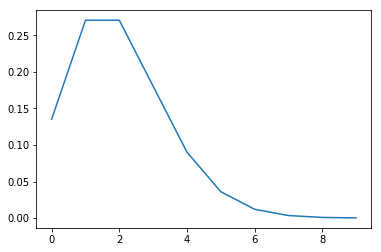

In [502]:
iterP = iterationPrior()
iterP.set_value(2.)
plt.plot(range(10), iterP.pmf(range(10)))

[[10.5 20. ]
 [23.  20. ]
 [19.  18. ]
 [12.5 17.5]
 [17.5 30. ]
 [12.  24.5]
 [12.  17. ]
 [17.  16.5]
 [21.5  9. ]]


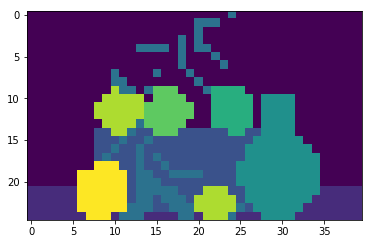

In [536]:
D1,D2 = (25,40)
smallMap = targetObjectMap.resize((D2,D1))
bmo = baseObjectMap(smallMap)
print bmo.objectCenters
plt.imshow(bmo.objectMap)

In [537]:
cpRows = [5, 10, 15]
cpCols = [10, 20, 30]
cpI,cpJ = np.meshgrid(cpRows,cpCols)
controlPoints = np.array([cpI.flatten(),cpJ.flatten()],dtype=floatX).T

# controlPoints = np.array([cpI.flatten(),cpJ.flatten()],dtype=floatX).T
# controlPoints = bmo.objectCenters
# controlPoints = np.array([20,12],dtype=floatX,ndmin=2)

globalAffineParamDictList = global_affine_distortion_set(big=1.1, small=.9, rotate=0, shear = 0, translate=0)
gad = distortions(controlPoints,kind='global',distortionParamDictList=globalAffineParamDictList)

# localAffineParamDictList = local_affine_distortion_set(big=2.7, small=-2.7)
# gad = distortions(controlPoints,kind='local',distortionParamDictList=localAffineParamDictList)

print gad.numControlPoints
print gad.numDistortions

act = activations(actP,gad)
actPval = np.empty((act.numActivationStates,act.numActivationVars))
actPval[0,:] = .5  #ON state
actPval[1,:] = .5  ##OFF state
M = 10000
samp1hot = act.sample(M=M, pval=actPval)
print 'ON prob is: %f, should be: %f' %(samp1hot[:,0,:].astype(floatX).sum()/(M*act.numActivationVars),actPval[0,0])
print 'OFF prob is: %f, should be: %f' %(samp1hot[:,1,:].astype(floatX).sum()/(M*act.numActivationVars),actPval[1,0])
sampCanonical = act.sample(M=M, pval=actPval, kind='canonical')
print 'ON prob is: %f, should be: %f' %(sampCanonical.astype(floatX).mean(), actPval[0,0])

9
16
ON prob is: 0.499718, should be: 0.500000
OFF prob is: 0.500282, should be: 0.500000
ON prob is: 0.499837, should be: 0.500000


In [538]:
len(gad.distortionParamDictList)

16

(10000, 4, 1)
prob is: 0.000000, should be: 0.000000
prob is: 1.000000, should be: 1.000000
prob is: 0.000000, should be: 0.000000
prob is: 0.000000, should be: 0.000000


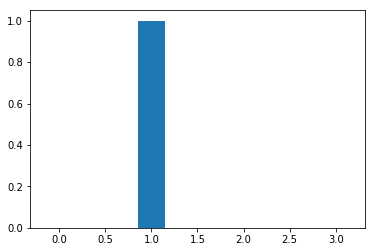

In [539]:
it = iterations(iterP,numIterationVars=1,numIterationStates=4)
itPval = np.empty((it.numIterationStates,it.numIterationVars))

itPval[0,:] = 0.  #no iterations
itPval[1,:] = 1.0  ##1 iterations
itPval[2,:] = .0  ##2 iterations
itPval[3,:] = 0.0  ##3 iterations

M = 10000
samp1hot = it.sample(M=M, pval=itPval)
print samp1hot.shape

for i,p in enumerate(itPval[:,0]):
    print 'prob is: %f, should be: %f' %(samp1hot[:,i,:].astype(floatX).sum()/(M*it.numIterationVars),p)

sampCanonical = it.sample(M=M, pval=itPval, kind='canonical')
sampCanonical.shape
_=plt.hist(sampCanonical,bins=[0,1,2,3,4],density=True, align='left', rwidth=.3)
# for i,p in enumerate(pval[:,0]):
#     print 'prob is: %f, should be: %f' %(samp1hot[:,i,:].astype(floatX).sum()/(M*it.numIterationVars),p)

(1, 9, 1000)
[1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1
 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0
 1 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1]
[1]


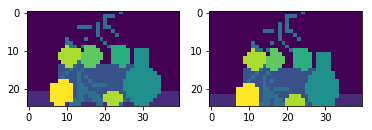

In [556]:
lom = latentObjectMap(act,it,bmo)
plt.subplot(1,2,1)
plt.imshow(lom._get_base_map())
plt.subplot(1,2,2)
warped1hot,actSample,itSample,dp = lom.sample(M=1,activationProbs=actPval,iterationProbs=itPval, kind='1hot')
print warped1hot.shape
targetZ1hot = warped1hot[:1]
targetAct = actSample[0,:]
targetIter = itSample[0,:]
_=lom.convert1hot_to_image(targetZ1hot,show=True)
print targetAct
print targetIter

(-1.9500000000000002, 40.95, -1.2521453004683107, 26.295051309834523)

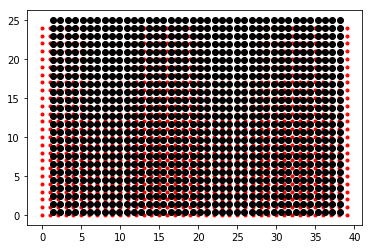

In [557]:
plt.plot(lom.baseObjectMap.sourcePoints[:,0],lom.baseObjectMap.sourcePoints[:,1], 'r.')
plt.plot(dp[:,0],dp[:,1], 'ko')
plt.axis('image')

In [476]:
flurb = lom._get_base_map()


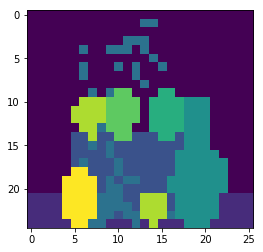

In [490]:
plt.imshow(flurb.flatten().reshape((D1,D2)))

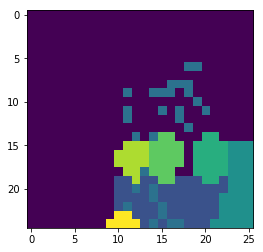

In [497]:
blarg = griddata(lom.baseObjectMap.sourcePoints[:,[0,1]]+5, flurb.T.flatten(), lom.baseObjectMap.sourcePoints[:,[0,1]], method='nearest').reshape((D2,D1)).T
plt.imshow(blarg)

In [487]:
lom.baseObjectMap.sourcePoints

array([[ 0.,  0.],
       [ 0.,  1.],
       [ 0.,  2.],
       ...,
       [25., 22.],
       [25., 23.],
       [25., 24.]])

In [465]:
from scipy.ndimage import map_coordinates

In [438]:
map_coordinates(flurb, dp)

RuntimeError: invalid shape for coordinate array

In [368]:
flurb = lom._get_base_map()
flurb.shape

(25, 40)

In [24]:
##windows
DPrime1,DPrime2 = 2*D1, 2*D2 ##this gives the "native resolution" of the windows
shape = (DPrime1,DPrime2)
baseShape = (12, 12) ##size in pixels of the smallest probes
numScales = 4 ##number of probe sizes between smallest and native resolution
stride = 1 ##how far each probe travels when constructing probes, as a fraction of probe size
numRandProbes = 220 ##number of non-contiguous probes
randProbeOrder = (2, 3) ##non-contig probes will contain this many patches (range of)
windows = probes() ##instantiate a windows object
W = windows.make_windows(shape, baseShape, numScales, stride, numRandProbes, randProbeOrder) ##create the windows

##now, we want to downsample the windows to a more manageable "working" resolution.
##to do this, we first calculate all of the downsamples that have integer dimensions and preserve the aspect ratio
##we set workingScale=n to choose the nth smallest resolution as our working resolution. 
##NOTE: THIS DOESN'T REALLY WORK BECAUSE EACH NATIVE RESOLUTIONI NEEDS TO BE CLEANLY DIVISIBLE BY WORKING RESOLUTION.
##FOR THE "UPSAMPLING" OF Z TO WORK. SO, BEST JUST TO WORK WITH NATIVE RESOLUTIONS THAT ARE POWERS OF SOME NUMBER.
##LIKE, SAY, 2.
#resolutions, workingResolution = windows.resolve(shape, workingScale=-1) 

##Given the above, we'll just set the working resolution by hand
workingResolution = (64,64)

##next, we downsample the windows, and set_value
windows.set_value(windows.reshape(W, workingResolution),flatten=True)

In [27]:
vi.responses.windows.shape

(229, 4096)

total observations: 229


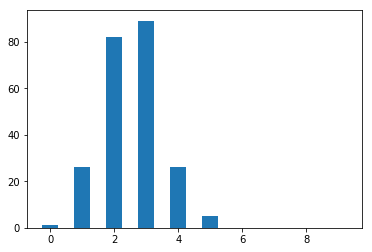

In [25]:
noize = noiseParams()

##response object
r = behavior(lom,noize)
pon = .95

poff = 0.0500000001
r.set_values(windows=windows)
data = r.sample(targetZ1hot,pon,poff)
r.set_values(data=data)
K = r.Z._get_num_objects()

print 'total observations: %d' %(r.N)
_=plt.hist(r.observations,bins=range(0,K+2),rwidth = .5, align='left')

In [26]:
iqA = inferQZ()
iqt = inferQZ()
oNP = optimizeNoiseParams()
vi = variationalImageRegistration(r,iqA,iqt,oNP)

##inference algorithm parameters
pOn_init, pOff_init = .95, 0.05
densityOfNoiseParamGrid = 50
numSamplesForComputingObjectCountProbs = 6
maxNumIterations = 10
trainTestSplit = .9
trainRegSplit = .8

epochs =   vi.run_VI(
                     pOn_init, pOff_init, \
                     densityOfNoiseParamGrid, \
                     numSamplesForComputingObjectCountProbs, \
                     maxNumIterations, \
                     trainTestSplit, trainRegSplit, \
                     randinit = True
                     )

!new best!
ELBO: -1151.122070
goodness of fit: -1164.946167
posterior_entropy: 13.824134
mean log of predictive distribution over test samples: -6.031566
percent correct over test samples: 7.317073


!new best!
ELBO: -238.238235
goodness of fit: -238.257584
posterior_entropy: 0.019342
mean log of predictive distribution over test samples: -1.494730
percent correct over test samples: 17.073171




KeyboardInterrupt: 

In [28]:
foo = to_one_hot_func(vi.responses.Z.baseObjectMap.objectMap.astype(intX).flatten(), 9).astype(intX).T.reshape((1,9,D1*D2))

In [ ]:
np.random.multinomial

In [ ]:
plt.plot(vi.ELBO_history[:epochs])

In [ ]:
plt.plot(vi.percentCorrect_history[:epochs])

In [ ]:

plt.plot(vi.bestQA[0,:], 'k')
plt.plot(targetAct, 'r')

In [ ]:
print vi.bestNoiseParam
print vi.bestPercentCorrect

In [ ]:
warpedCanonical,actSample,itSample = lom.sample(M=1,activationProbs=vi.bestQA,iterationProbs=vi.bestQt, kind='canonical')

In [ ]:
plt.subplot(1,3,1)
plt.imshow(lom.baseObjectMap.objectMap)
plt.title('base')
plt.subplot(1,3,2)
_=lom.convert1hot_to_image(targetZ1hot,show=True)
plt.title('target')
plt.subplot(1,3,3)
plt.imshow(warpedCanonical[0])
plt.title('learned warp')

In [ ]:
vi.bestQt

### ==============================TOSSED============================================

In [ ]:
pdb